[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1aiL3qqk3CgCPhBuMDaRYUSBlUjh31-d9?usp=sharing)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
import autograd.numpy as npy
from autograd import grad
from autograd import elementwise_grad

In [ ]:
class LogisticRegression():
    def __init__(self, fit_intercept=True):
        '''
        :param fit_intercept: Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).
        '''
        self.fit_intercept = fit_intercept
        self.coef_ = None #Replace with numpy array or pandas series of coefficients learned using using the fit methods
        self.thetas = [] ##for plotting
        self.costs = []
        self.X = None
        self.y = None

        pass

    def fit(self, X, y, n_iter=100000, lr=0.01, lr_type='constant'):
        
        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()
        
        if isinstance(y,pd.Series):
            y = y.to_numpy()

        m = X.shape[1]
        n = len(y)  
        y = y.reshape(n,1)
        if self.fit_intercept == True:
            theta = np.random.randn(m+1,1)
            X0 = np.ones((n,1))
            X = np.append(X0,X,axis = 1)
        elif self.fit_intercept == False:
            theta = np.random.randn(m,1)

        self.X = X
        self.y = y

        ## For 
        # n = no. of samples
        # m = no. of features
        # X : n x m
        # theta : m x 1
        # y : n x 1

        for it in range(1,n_iter+1):
            if lr_type == 'constant':
                c = 1
            elif lr_type == 'inverse':
                c = 1/(it+1)

            Z = np.dot(X,theta)  
            y_hat = self.sigmoid(Z)
            # cost = self.cost(y,y_hat)
            dtheta = (1/n)*np.dot( X.T,y_hat-y) 
            theta = theta - c*lr*dtheta

            # Keeping track of our weights
            self.thetas.append(theta)
            
            # Keeping track of our cost function value
            # self.costs.append(cost)

        self.coef_ = theta
        return

    def sigmoid(self,Z):
        return 1/(1+npy.exp(-Z))

    def cost(self,theta): 
        X = self.X
        y = self.y
        Z = npy.dot(X,theta)  
        y_hat = self.sigmoid(Z)

        y1 = y*npy.log(y_hat)
        y2 = (1-y)*npy.log(1-y_hat)
        # cost = -(1/len(y))*npy.sum( y*npy.log(y_hat) + (1-y)*npy.log(1-y_hat))
        cost = -(1/len(y))*npy.sum(y1 + y2)
        return cost

    def fit_autograd(self, X, y, n_iter=10000, lr=0.01, lr_type='constant'):

        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()
        
        if isinstance(y,pd.Series):
            y = y.to_numpy()

        m = X.shape[1]
        n = len(y)  
        y = y.reshape(n,1)
        if self.fit_intercept == True:
            theta = np.random.randn(m+1,1)
            X0 = np.ones((n,1))
            X = np.append(X0,X,axis = 1)
        elif self.fit_intercept == False:
            theta = np.random.randn(m,1)

        self.X = X
        self.y = y

        ag = elementwise_grad(self.cost)
        for it in range(1,n_iter+1):
            if lr_type == 'constant':
                c = 1
            elif lr_type == 'inverse':
                c = 1/(it+1)

            cost = ag(theta)
            
            theta -= c*lr*cost

            # Keeping track of our weights
            self.thetas.append(theta)
            
            # Keeping track of our cost function value
            self.costs.append(cost)
            
        self.coef_ = theta
        return

    
    def predict(self, X):
            
        if isinstance(X,pd.DataFrame):
            X = X.to_numpy()

        if self.fit_intercept == True:  
            m = X.shape[0]
            X0 = np.ones((m,1))
            X = np.append(X0,X,axis = 1)
        
        y_hat = self.sigmoid(X.dot(self.coef_))
        y_hat = y_hat.reshape(len(y_hat),)
        # print(y_hat)
        for i in range(len(y_hat)):
                if(y_hat[i]<=0.5):
                    y_hat[i]=0
                else:
                    y_hat[i]=1
        return pd.Series(y_hat)

    def accuracy(self,y_hat,y):

        assert(y_hat.size == y.size)
        true_pred = 0
        for i in range(y_hat.size):
            if y_hat[i]==y[i]:
                true_pred+=1

        accu = true_pred/y.size
        return accu*100

    def plot(self,X,y):
        """
        Plots the decison boundary of the learned model.
        Note : The code will break if the number of columns in X is more than 2.
        Ref. : https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html
        """
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = .02  # step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()]).to_numpy()
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(4, 3))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())

        plt.savefig("./q1d.png")
        plt.show()
        return


### Dataset Preprocessing

In [ ]:
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer['target'])

## Normalization of X
for column in X.columns:
    X.loc[:,column] = (X.loc[:,column] - X.loc[:,column].min())/(X.loc[:,column].max() - X.loc[:,column].min())

### Part - a

In [ ]:
def q_a(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    clf = LogisticRegression()
    clf.fit(X,y)
    pred = clf.predict(X)
    print("\nPart a:")
    print("Accuracy: ",clf.accuracy(pred,y))
    return

q_a(X,y)


Part a:
Accuracy:  97.89103690685414


### Part - b

In [ ]:
def q_b(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    clf = LogisticRegression()
    clf.fit_autograd(X,y)
    pred = clf.predict(X)
    print("\nPart b:")
    print("Accuracy: ",clf.accuracy(pred,y))
    return

q_b(X,y)


Part b:
Accuracy:  92.09138840070298


### Part - c

In [ ]:
def q_c(X,y):
    X = X.to_numpy()
    y = y.to_numpy()
    print("\nPart c:")
    cnt = 1
    accu = []
    kf = KFold(n_splits=3)
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression()
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test)
        accu.append(clf.accuracy(pred,y_test))
        print(cnt,". Accuracy: ",accu[cnt-1])
        cnt+=1
    print("Overall/Average Accuracy: ",sum(accu)/len(accu))
    return

q_c(X,y)


Part c:
1 . Accuracy:  92.63157894736842
2 . Accuracy:  96.84210526315789
3 . Accuracy:  97.35449735449735
Overall/Average Accuracy:  95.6093938550079


### Part - d


Part d:
Accuracy:  90.15817223198594


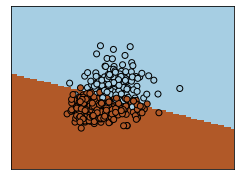

In [ ]:
def q_d(X,y):
    X = X.iloc[:,[1,2]]
    # print(X)
    X = X.to_numpy()
    y = y.to_numpy()
    clf = LogisticRegression()
    clf.fit(X,y)
    pred = clf.predict(X)
    print("\nPart d:")
    print("Accuracy: ",clf.accuracy(pred,y))
    clf.plot(X,y)
    return

q_d(X,y)